In [2]:
import cv2
import dlib
import math
import time
import os

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Charger le détecteur de visages et le prédicteur de points clés de Dlib
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(r"..\shape_predictor_68_face_landmarks.dat")

points_cles_interessants = [48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67]

seuil = 1  # Threshold pour détecter des changements significatifs dans les lèvres


In [3]:
def lips_points_labios(imagen):
    lips_points = []

    # Detect faces
    faces = detector(imagen)

    # For each detected face, predict keypoints
    for face in faces:
        landmarks = predictor(imagen, face)

        lips_points = []

        for n in points_cles_interessants:  # Lip points indices in the 68-point model
            x = landmarks.part(n).x
            y = landmarks.part(n).y
            lips_points.append((x, y))
            
        break

    return np.array(lips_points)

def angulo_boca(comisura_labio_izq, comisura_labio_der):
    global angulo_suavizado
    
    angulo_suavizado = None
    factor_suavizado = 0.2  # Adjust this value (0.1-0.5) for smoother or sharper results

    dx = comisura_labio_der[0] - comisura_labio_izq[0]
    dy = comisura_labio_der[1] - comisura_labio_izq[1]

    # Calculate the current angle
    angulo_actual = math.degrees(math.atan2(dy, dx))

    # If no previous angle, initialize with the current one
    if angulo_suavizado is None:
        angulo_suavizado = angulo_actual
    else:
        # Smooth the angle
        angulo_suavizado = (1 - factor_suavizado) * angulo_suavizado + factor_suavizado * angulo_actual

    return angulo_suavizado

def rotar_imagen_angulo_0(imagen, angulo, point1, point2):
    centro_punto_D1 = (point1[0] + point2[0]) / 2
    centro_punto_D2 = (point1[1] + point2[1]) / 2
    centro = (centro_punto_D1, centro_punto_D2)
    rotation_matrix = cv2.getRotationMatrix2D(centro, angulo, 1.0)
    imagen_rotada = cv2.warpAffine(imagen, rotation_matrix, (imagen.shape[1], imagen.shape[0]))
    return imagen_rotada


In [4]:
def normalize_keypoints(points):
    """
    Normalize a set of keypoints in a frame by centering on the centroid
    and scaling by the maximum distance from the centroid.
    
    Args:
    - points (numpy array): Array of size (K, 2), where:
        K: Number of keypoints in a frame.
        2: Coordinates (x, y).
    
    Returns:
    - normalized_points (numpy array): Keypoints normalized to the range [-1, 1].
    """
    points = np.array(points)  # Ensure it is a NumPy array

    # 1. Center on the centroid
    centroid = points.mean(axis=0)  # Frame centroid
    centered_points = points - centroid

    # 2. Scale by the maximum distance from the centroid
    max_distance = np.linalg.norm(centered_points, axis=1).max()  # Maximum distance to the centroid
    if max_distance == 0:
        max_distance = 1e-8  # Avoid division by zero
    
    scaled_points = centered_points / max_distance  # Normalize to the range [-1, 1]
    
    return scaled_points


In [5]:
def dessiner_levres(lips_points, image):
    for tupla in lips_points:
        cv2.circle(image, (tupla[0], tupla[1]), 1, (0, 255, 0), -1)
        
    cv2.imshow("Image rotée", image)
    return image


In [6]:
def temps_reel():
    # Video capture from a file
    cap = cv2.VideoCapture(0)

    while True:
        # Capture the video frame
        ret, frame = cap.read()
        if not ret:
            continue

        # Processing lip points
        lips_points_antes_rotacion = lips_points_labios(frame)
        
        if lips_points_antes_rotacion.size != 0 and len(lips_points_antes_rotacion) == len(points_cles_interessants):
            print(lips_points_antes_rotacion)

            indice_comisura_iz = points_cles_interessants.index(48)
            indice_comisura_der = points_cles_interessants.index(54)
            
            # Angle calculation and image rotation
            angulo = angulo_boca(lips_points_antes_rotacion[indice_comisura_iz], lips_points_antes_rotacion[indice_comisura_der])
            imagen_rotada = rotar_imagen_angulo_0(frame, angulo, lips_points_antes_rotacion[indice_comisura_iz], lips_points_antes_rotacion[indice_comisura_der])
            
            # Normalize lip points
            lips_points = lips_points_labios(imagen_rotada)
            
            print(normalize_keypoints(lips_points))
            
            dessiner_levres(lips_points, imagen_rotada)
        else:
            cv2.imshow("Image rotée", frame)

        # Exit the loop if the 'q' key is pressed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release the video and close windows
    cap.release()
    cv2.destroyAllWindows()

temps_reel()


[[278 370]
 [286 366]
 [294 364]
 [299 365]
 [305 363]
 [314 363]
 [322 365]
 [315 372]
 [307 376]
 [301 377]
 [295 377]
 [287 375]
 [282 370]
 [294 368]
 [300 368]
 [306 367]
 [319 365]
 [306 369]
 [300 371]
 [294 371]]
[[-0.93414539 -0.05043508]
 [-0.58329266 -0.18200485]
 [-0.27629652 -0.26971803]
 [-0.01315698 -0.18200485]
 [ 0.24998257 -0.26971803]
 [ 0.6008353  -0.22586144]
 [ 0.99554462 -0.09429167]
 [ 0.6008353   0.21270447]
 [ 0.24998257  0.30041765]
 [-0.01315698  0.34427424]
 [-0.27629652  0.30041765]
 [-0.62714925  0.21270447]
 [-0.75871902 -0.05043508]
 [-0.27629652 -0.05043508]
 [-0.01315698 -0.05043508]
 [ 0.24998257 -0.05043508]
 [ 0.82011825 -0.05043508]
 [ 0.24998257  0.0372781 ]
 [ 0.03069961  0.08113469]
 [-0.27629652  0.0372781 ]]
[[279 369]
 [286 365]
 [294 362]
 [300 363]
 [306 361]
 [315 361]
 [324 363]
 [316 371]
 [308 375]
 [302 377]
 [295 377]
 [287 375]
 [282 369]
 [294 367]
 [300 367]
 [307 366]
 [320 364]
 [307 368]
 [301 370]
 [295 370]]
[[-0.94954494 -0.

In [29]:
def crear_grafica(historial):
    plt.plot(historial, marker='o', linestyle='-', color='b', label='Cambios entre frames')

    # Personalización de la gráfica
    
    plt.xlabel("Índice del Frame")
    plt.ylabel("Cambio")
    plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)  # Línea en y=0
    plt.grid(alpha=0.3)
    #plt.legend()

    # Mostrar la gráfica
    plt.show()
    
def grafica_histograma(historial):
    # Crear un histograma
    plt.figure(figsize=(10, 5))
    plt.hist(historial, bins=len(np.unique(historial)), color='blue', alpha=0.7, edgecolor='black')
    
    # Etiquetas y título del histograma
    plt.xlabel("Valores")
    plt.ylabel("Frecuencia")
    
    # Mostrar el histograma
    plt.show()

In [8]:
def procesar_video(ruta_video):
    historial_diferencias = []
    historial_puntos = []
    
    historial_diferencias_por_dimension = []
    
    for dimension in points_cles_interessants:
        historial_diferencias_por_dimension.append([])
    
    frames_totales = 0   
    frames_sin_omitir = 0
    
    lips_points_anterior = np.empty(0)

    # Captura de video desde un archivo
    cap = cv2.VideoCapture(ruta_video)
    
    # tiempo real
    #cap = cv2.VideoCapture(0)

    while True:
        # Capturar el frame del video
        ret, frame = cap.read()
        if not ret:
            break

        # Procesamiento de los puntos de los labios
        lips_points_antes_rotacion = lips_points_labios(frame)
        if len(lips_points_antes_rotacion) != len(points_cles_interessants):
            break

        indice_comisura_iz = points_cles_interessants.index(48)
        indice_comisura_der = points_cles_interessants.index(54)
        
        # Cálculo del ángulo y rotación de la imagen
        angulo = angulo_boca(lips_points_antes_rotacion[indice_comisura_iz], lips_points_antes_rotacion[indice_comisura_der])
        imagen_rotada = rotar_imagen_angulo_0(frame, angulo, lips_points_antes_rotacion[indice_comisura_iz], lips_points_antes_rotacion[indice_comisura_der])
        
        # Normalizar los puntos de los labios
        lips_points = lips_points_labios(imagen_rotada)
        
        lips_points_normalizados = normalize_keypoints(lips_points)
        
        frames_totales += 1
        
        if lips_points_anterior.size != 0:
            # Calcular la distancia promedio entre los puntos actuales y los anteriores
            distances = np.linalg.norm(lips_points - lips_points_anterior, axis=1)
            mean_distance = np.mean(distances)
            historial_diferencias.append(mean_distance)
            dessiner_levres(lips_points,imagen_rotada)
            
        # Almacenar puntos históricos
        historial_puntos.append(lips_points_normalizados.sum(axis=1))
        lips_points_anterior = lips_points

        # Romper el bucle si se presiona la tecla 'q'
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Liberar el video y cerrar las ventanas
    cap.release()
    cv2.destroyAllWindows()
    crear_grafica(historial_diferencias)
    grafica_histograma(historial_diferencias)
    

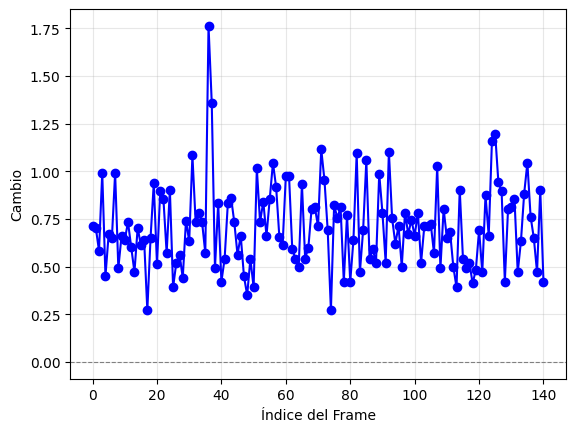

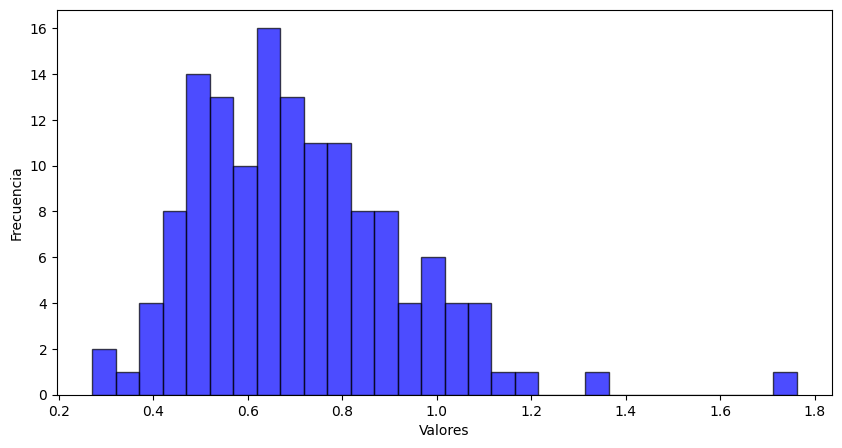

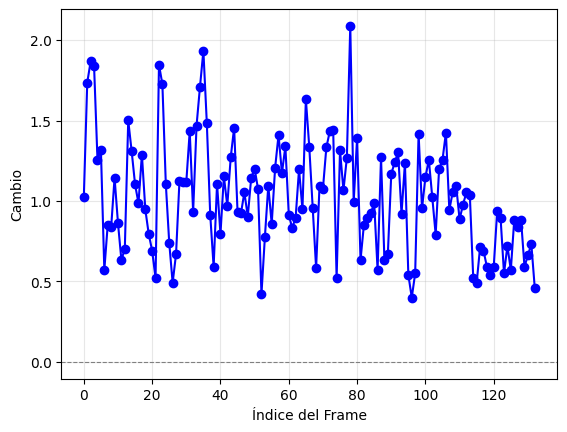

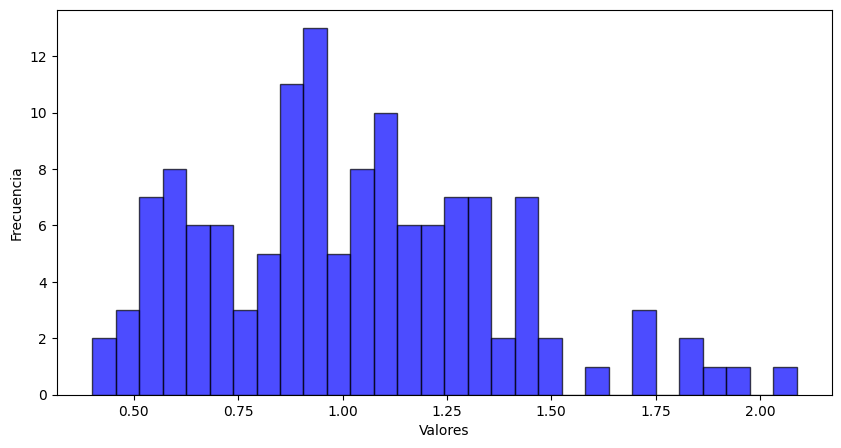

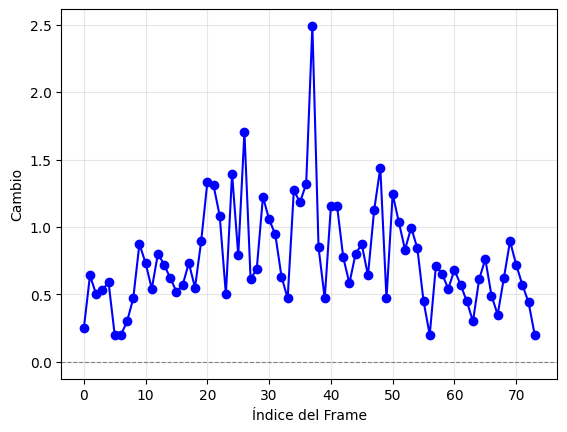

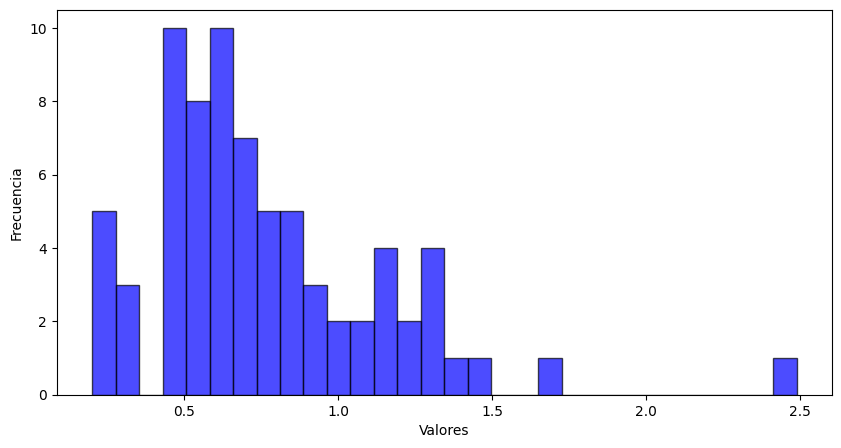

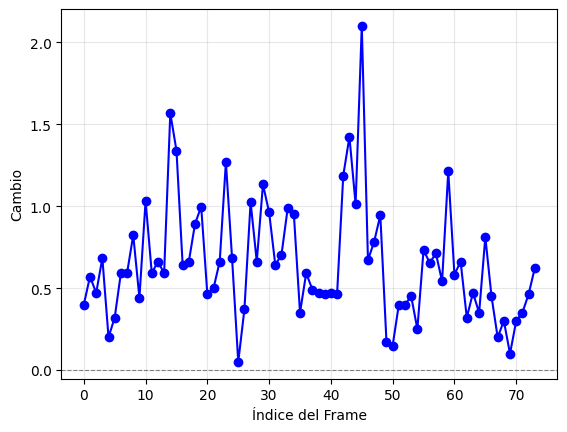

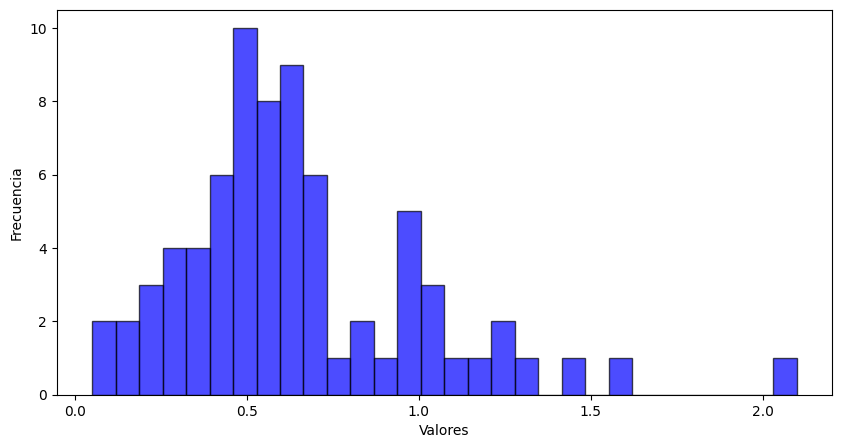

In [84]:
#####################################################################################################################
# Ejecucion expetimental, estudio de la varianza de frame y treshold
    
# Ejemplo de uso
ruta_video_hola_lento = r"..\data\analyse\lento_buenos_dias.mp4"
ruta_video_hola_rapido = r"..\data\analyse\rapido_buenos_dias.mp4"
ruta_video_quieto_largo = r"..\data\analyse\quieto_largo.mp4"
ruta_video_quieto_rapido = r"..\data\analyse\quieto_rapido.mp4"

procesar_video(ruta_video_quieto_rapido)
procesar_video(ruta_video_hola_rapido)

ruta_data_set_1 = r"..\data\analyse\bbaf2n.mpg"
ruta_data_set_2 = r"..\data\analyse\bbaf3s.mpg"

procesar_video(ruta_data_set_1)
procesar_video(ruta_data_set_2)

In [77]:
def procesar_video_sans_rotacion(ruta_video):
    historial_diferencias = []
    historial_puntos = []
    
    historial_diferencias_por_dimension = []
    
    for dimension in points_cles_interessants:
        historial_diferencias_por_dimension.append([])
    
    frames_totales = 0   
    frames_sin_omitir = 0
    
    lips_points_anterior = np.empty(0)

    # Captura de video desde un archivo
    cap = cv2.VideoCapture(ruta_video)
    
    # tiempo real
    #cap = cv2.VideoCapture(0)

    while True:
        # Capturar el frame del video
        ret, frame = cap.read()
        if not ret:
            break

        # Procesamiento de los puntos de los labios
        lips_points_antes_rotacion = lips_points_labios(frame)
        if len(lips_points_antes_rotacion) != len(points_cles_interessants):
            break

        
        lips_points_normalizados = normalize_keypoints(lips_points_antes_rotacion)
        
        frames_totales += 1
        
        if lips_points_anterior.size != 0:
            # Calcular la distancia promedio entre los puntos actuales y los anteriores
            distances = np.linalg.norm(lips_points_antes_rotacion - lips_points_anterior, axis=1)
            mean_distance = np.mean(distances)
            historial_diferencias.append(mean_distance)
            dessiner_levres(lips_points_antes_rotacion,frame)
            
        # Almacenar puntos históricos
        historial_puntos.append(lips_points_normalizados.sum(axis=1))
        lips_points_anterior = lips_points_antes_rotacion

        # Romper el bucle si se presiona la tecla 'q'
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Liberar el video y cerrar las ventanas
    cap.release()
    cv2.destroyAllWindows()
    crear_grafica(historial_diferencias)
    grafica_histograma(historial_diferencias)

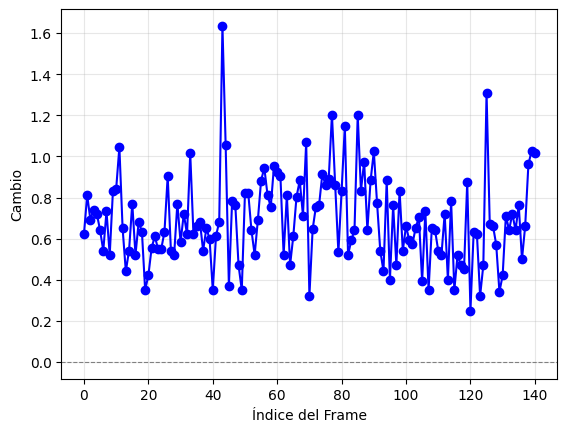

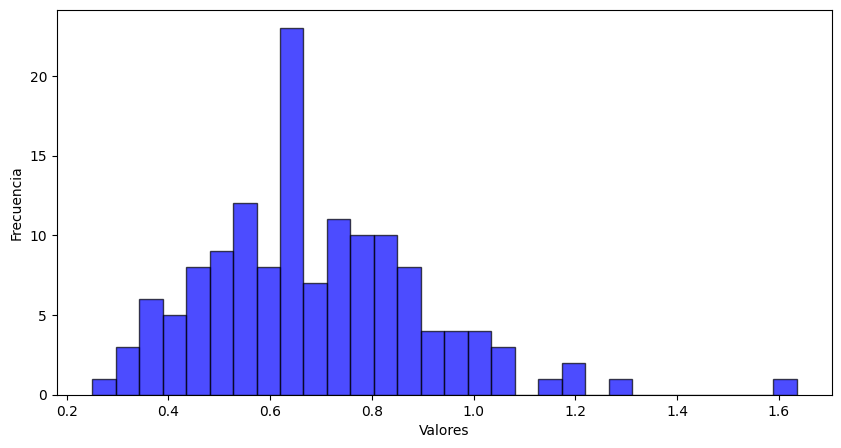

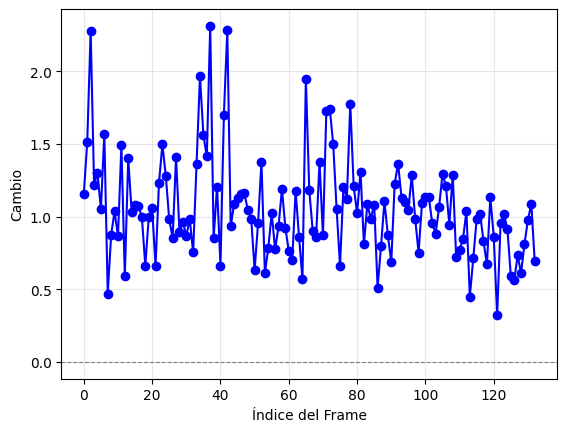

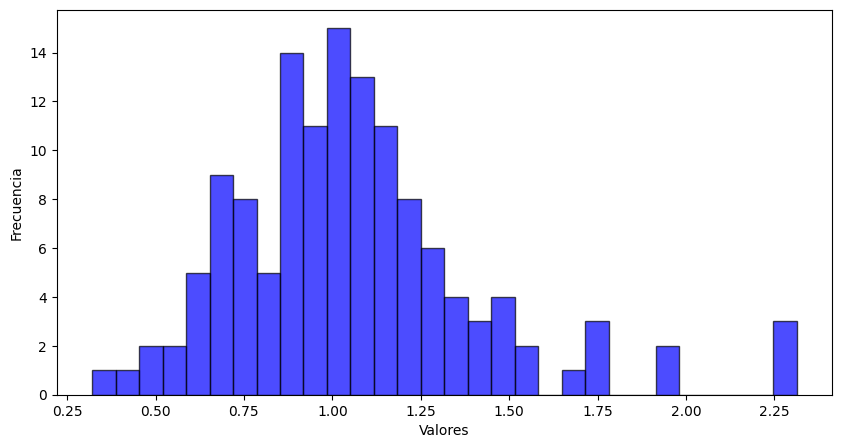

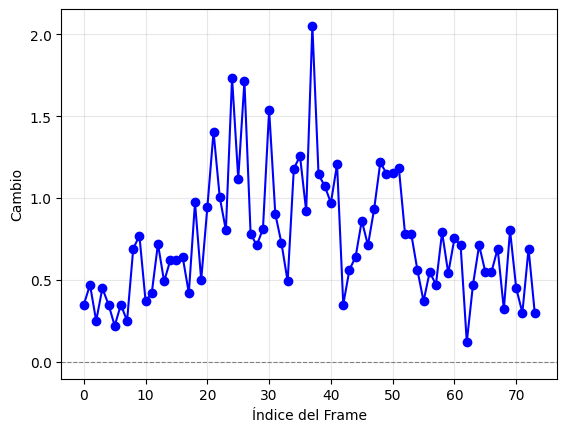

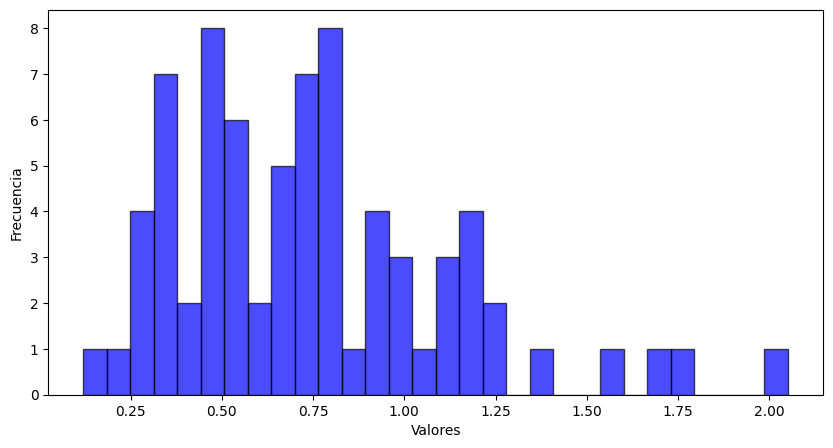

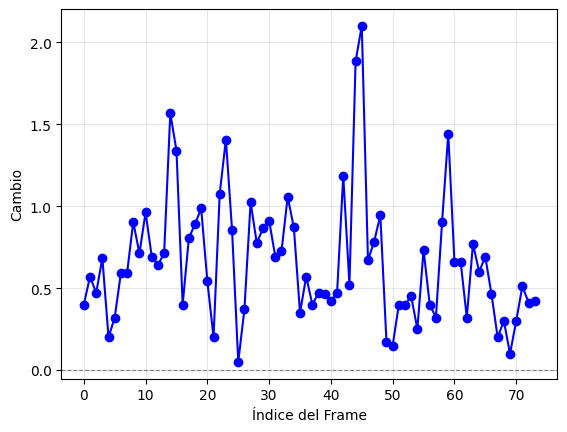

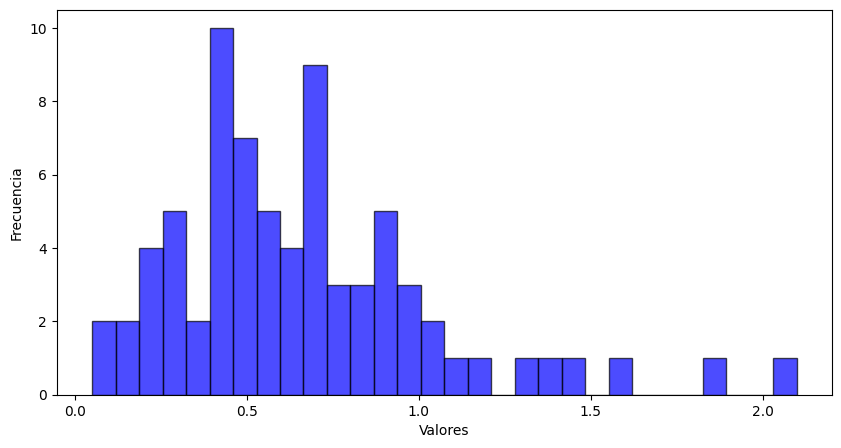

In [78]:
#####################################################################################################################
# Ejecucion expetimental, estudio de la varianza de frame y treshold
    
# Ejemplo de uso
ruta_video_hola_lento = r"..\data\analyse\lento_buenos_dias.mp4"
ruta_video_hola_rapido = r"..\data\analyse\rapido_buenos_dias.mp4"
ruta_video_quieto_largo = r"..\data\analyse\quieto_largo.mp4"
ruta_video_quieto_rapido = r"..\data\analyse\quieto_rapido.mp4"

procesar_video_sans_rotacion(ruta_video_quieto_rapido)
procesar_video_sans_rotacion(ruta_video_hola_rapido)

ruta_data_set_1 = r"..\data\analyse\bbaf2n.mpg"
ruta_data_set_2 = r"..\data\analyse\bbaf3s.mpg"

procesar_video_sans_rotacion(ruta_data_set_1)
procesar_video_sans_rotacion(ruta_data_set_2)

In [9]:
def lire(fichier):
    # Leer y mostrar contenido
    with open(fichier, "r") as f:
        contenue = f.read()

    # Mostrar el contenido
    print(contenue)

In [10]:
archivo = r"../data/analyse/s1/alignements/bbaf2n.align"
lire(archivo)

0 23750 sil
23750 29500 bin
29500 34000 blue
34000 35500 at
35500 41000 f
41000 47250 two
47250 53000 now
53000 74500 sil



In [20]:
import os
def split_video_to_labels_and_keypoints(video_path, intervals_file):
    # Leer el archivo de intervalos
    with open(intervals_file, 'r') as file:
        lines = file.readlines()

    # Cargar el video
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: No se pudo abrir el video {video_path}")
        raise Exception("El video no se ha podido abrir correctamente")

    # Lista para almacenar los datos estructurados
    labels = []
    labels_key_points = []
    
    antiguo_label = None

    for line in lines:
        start_frame, end_frame, label = line.strip().split()
        start_frame, end_frame = math.ceil(int(start_frame) / 1000), math.ceil(int(end_frame) / 1000)

        # Establecer la posición inicial del frame
        cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

        #print(f"Procesando frames para la etiqueta '{label}' desde el frame {start_frame} hasta {end_frame}...")
        
        if antiguo_label != label:
            
            #Cambio sin reconocimiento de keypoints
            if antiguo_label != None and np.any(np.array(key_points) == None):
                labels.pop()
            elif antiguo_label != None:
                labels_key_points.append(np.array(key_points))
                
            labels.append(label)
            key_points = []
            antiguo_label = label
            
        # Recorrer los frames del intervalo
        for frame_num in range(start_frame, end_frame):
            ret, frame = cap.read()
            if not ret:
                return (None,None)
            
            kp_antes_de_rotar = lips_points_labios(frame)
            
            if not( np.any(np.array(kp_antes_de_rotar) == None) or kp_antes_de_rotar.size == 0):
                indice_comisura_iz = points_cles_interessants.index(48)
                indice_comisura_der = points_cles_interessants.index(54)
                
                # Cálculo del ángulo y rotación de la imagen
                angulo = angulo_boca(kp_antes_de_rotar[indice_comisura_iz], kp_antes_de_rotar[indice_comisura_der])
                imagen_rotada = rotar_imagen_angulo_0(frame, angulo, kp_antes_de_rotar[indice_comisura_iz], kp_antes_de_rotar[indice_comisura_der])
                    
                kp = lips_points_labios(imagen_rotada)

                if not( np.any(np.array(kp) == None) or kp.size == 0):
                    key_points.append(np.array(normalize_keypoints(kp)))

            
    # Liberar recursos de OpenCV
    cap.release()
    #print("Procesamiento completado.")

    # Convertir la lista en un np.array estructurado
    return (np.array(labels),labels_key_points)

In [21]:

FIN_BLOQUE = "################################################################################"
FIN_ELEMENTO = "########"

def guardar_entrenamiento(labels, arrays, nombre_archivo):
    """
    Guarda las etiquetas y los arrays multidimensionales en un archivo de texto,
    agregándolos al final del archivo si ya existe.
    
    Args:
    labels (list): Lista de etiquetas.
    arrays (list): Lista de arrays de NumPy multidimensionales.
    nombre_archivo (str): Nombre del archivo donde se guardarán los datos.
    """
    try:
        with open(nombre_archivo, 'a') as f:  # Modo de adición ('a')
            for label, arr in zip(labels, arrays):
                f.write(f"{label}\n")  # Escribir la etiqueta
                for elm in arr:
                    np.savetxt(f, elm, delimiter=' ', fmt='%.6g')  # Guardar el array
                    f.write(f"{FIN_ELEMENTO}\n")
                f.write(f"\n{FIN_BLOQUE}\n")  # Separador entre bloques
    except Exception as e:
        raise Exception(f"Error al guardar los datos: {e}")
        
        
def leer_entrenamiento(nombre_archivo):
    """
    Lee las etiquetas y los arrays multidimensionales desde un archivo de texto,
    considerando los separadores FIN_ELEMENTO y FIN_BLOQUE.
    
    Args:
    nombre_archivo (str): Nombre del archivo desde donde se leerán los datos.
    
    Returns:
    tuple:
        - labels (list): Lista de etiquetas.
        - arrays (list): Lista de arrays de NumPy multidimensionales.
    """
    labels = []
    arrays = []
    try:
        with open(nombre_archivo, 'r') as f:
            while True:
                label = f.readline().strip()  # Leer la etiqueta
                if not label:  # Si no hay más etiquetas, terminar
                    break
                arr = []
                temp = []  # Para almacenar el sub-array actual
                while True:
                    line = f.readline().strip()
                    if line == FIN_BLOQUE:  # Fin del bloque
                        if temp:  # Guardar el último sub-array si existe
                            arr.append(np.array(temp))
                        break
                    elif line == FIN_ELEMENTO:  # Fin de un sub-array
                        if temp:  # Guardar el sub-array si existe
                            arr.append(np.array(temp))
                        temp = []  # Reiniciar el sub-array temporal
                    elif line:  # Evitar líneas vacías y procesar contenido
                        temp.append(list(map(float, line.split())))  # Convertir a flotantes
                if arr:
                    labels.append(label)
                    arrays.append(arr)  
                else:
                    print(f"Se ha recogido la la palabra {label}")
    except Exception as e:
        print(f"Error al leer los datos: {e}")
    
    return np.array(labels), arrays


In [22]:
def refinar_base_de_datos(archivo_refinado):
    
    try:
        os.remove(archivo_refinado)
    except:
        pass
    # Especifica la carpeta que quieres listar
    folder_path_ali = r'..\data\analyse\s1\alignements\\'
    folder_path_vid = r'..\data\analyse\s1\vid\\'

    # Lista los archivos y directorios en la carpeta
    alis = os.listdir(folder_path_ali)
    vids = os.listdir(folder_path_vid)
    
    alis = [folder_path_ali + file for file in alis]
    vids = [folder_path_vid + file for file in vids]
    
    contador = 0
    num_archivos = len(alis)
    
    for i in range(len(alis)):
        contador += 1
        print(f"Procesando {contador} de {num_archivos}")
        labels, arrays = split_video_to_labels_and_keypoints(vids[i],alis[i])
        if labels is None:
            print("Error al cargar el frame, pasando de video")
        else:
            guardar_entrenamiento(labels, arrays, archivo_refinado)
            print("Video bien guardado")
        
    print("FINNN")

In [23]:
archivo_refinado = r"..\data\analyse\s1_petit.txt"
refinar_base_de_datos(archivo_refinado)

Procesando 1 de 2
Video bien guardado
Procesando 2 de 2
Video bien guardado
FINNN


In [35]:
def calcular_limite_longitud(secuencias):
    """
    Calcula el límite de longitud para secuencias basado en el promedio + 2 desviaciones estándar.
    
    Args:
        secuencias (list of list): Lista de secuencias, donde cada secuencia es una lista de puntos clave o frames.
    
    Returns:
        int: Límite recomendado para la longitud de las secuencias.
    """
    longitudes = [len(seq) for seq in secuencias]
    promedio = np.mean(longitudes)
    desviacion_estandar = np.std(longitudes)
    limite = int(promedio + 2 * desviacion_estandar)
    return limite

sil
24


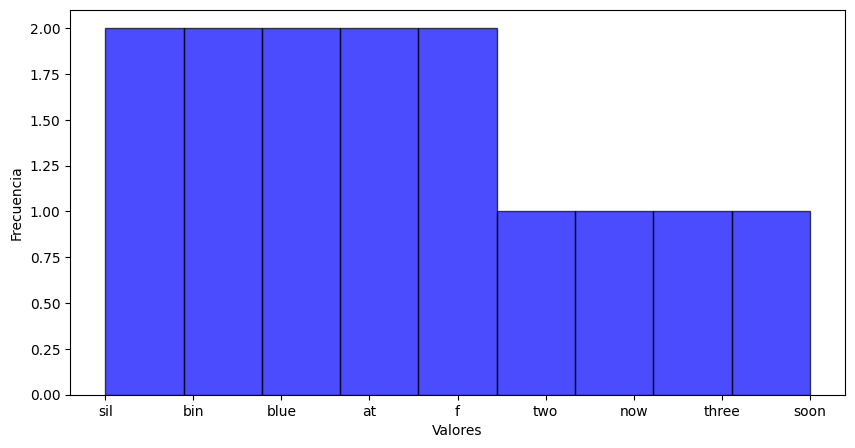

In [36]:

archivo_refinado = r"..\data\analyse\s1_petit.txt"
labels, arrays = leer_entrenamiento(archivo_refinado)
print(labels[0])
print(len(arrays[0]))
grafica_histograma(labels)

Se ha recogido la la palabra sp
Se ha recogido la la palabra sp
Se ha recogido la la palabra sil
Se ha recogido la la palabra sil
Se ha recogido la la palabra place
Se ha recogido la la palabra blue
Se ha recogido la la palabra in
Se ha recogido la la palabra o
Se ha recogido la la palabra sp
Se ha recogido la la palabra sp
Se ha recogido la la palabra sil
Se ha recogido la la palabra sp
Se ha recogido la la palabra sp
Se ha recogido la la palabra sil
Se ha recogido la la palabra sp
Etiqueta: i, Media de longitud: 4.282051282051282
Etiqueta: six, Media de longitud: 7.77
Etiqueta: three, Media de longitud: 6.424242424242424
Etiqueta: m, Media de longitud: 4.25
Etiqueta: soon, Media de longitud: 9.518072289156626
Etiqueta: e, Media de longitud: 3.5128205128205128
Etiqueta: x, Media de longitud: 4.475
Etiqueta: two, Media de longitud: 6.17
Etiqueta: one, Media de longitud: 5.3
Etiqueta: r, Media de longitud: 4.95
Etiqueta: c, Media de longitud: 5.275
Etiqueta: blue, Media de longitud: 6.2

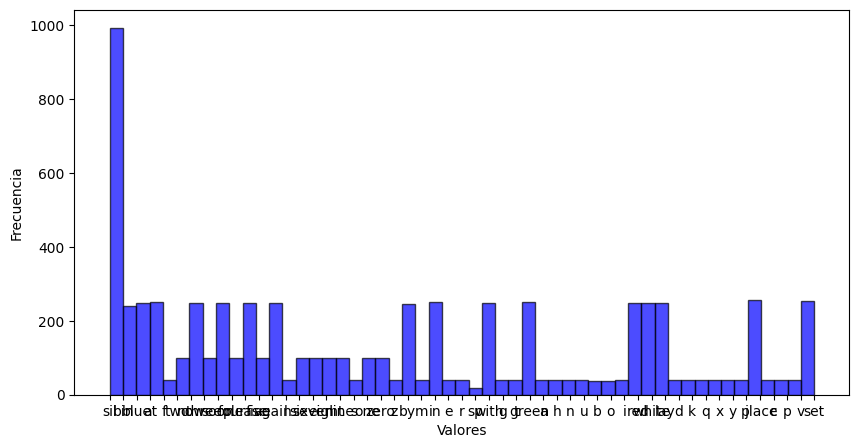

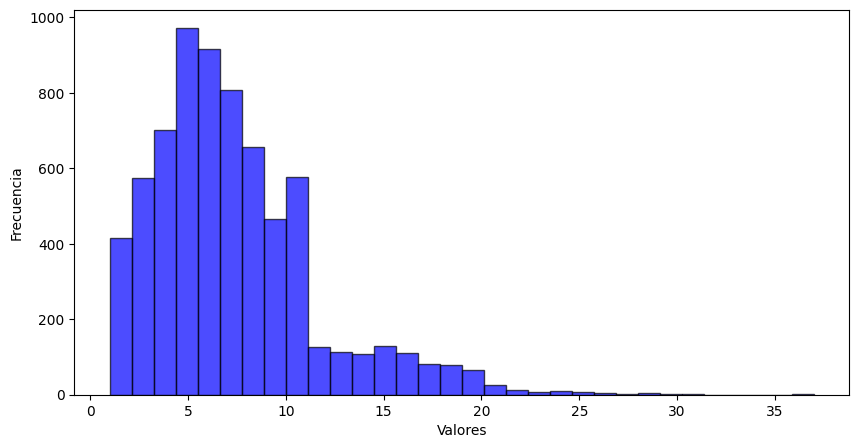

Cortaremos todo dato que tenga un tamaño superior a 15


In [40]:
from collections import Counter
from statistics import mean

# Asumiendo que ya tienes las etiquetas y los arrays leídos
archivo_refinado = r"..\data\processed\s1.txt"
labels, arrays = leer_entrenamiento(archivo_refinado)

# Calcula las longitudes de los arrays
longitudes = [len(elemento) for elemento in arrays]

# Calcula la media de longitud por etiqueta
longitudes_por_label = {}
for label in set(labels):
    longitudes_label = [longitudes[i] for i in range(len(labels)) if labels[i] == label]
    longitudes_por_label[label] = mean(longitudes_label)

# Imprime el resultado
for label, media in longitudes_por_label.items():
    print(f"Etiqueta: {label}, Media de longitud: {media}")

# Opcional: graficar histogramas si es relevante
grafica_histograma(labels)
grafica_histograma(longitudes)
print(f"Cortaremos todo dato que tenga un tamaño superior a {calcular_limite_longitud(arrays)}")


In [42]:
def aplicar_padding(secuencias, longitud_objetivo):
    """
    Aplica padding a todas las secuencias para que tengan la misma longitud.
    
    Args:
        secuencias (list of list): Lista de secuencias, donde cada secuencia es una lista de puntos clave o frames.
        longitud_objetivo (int): Longitud fija deseada para todas las secuencias.
    
    Returns:
        np.array: Matriz con todas las secuencias rellenadas con padding (ceros).
    """
    secuencias_padded = []
    for secuencia in secuencias:
        secuencia = np.array(secuencia)
        # Si la secuencia es más corta que la longitud objetivo, agrega ceros al final
        if len(secuencia) < longitud_objetivo:
            padding = np.zeros(shape=(longitud_objetivo - len(secuencia),20,2)) 
            #print(secuencia.shape)
            
            secuencia_padded = np.concatenate((secuencia,padding))
            
        else:
            secuencia_padded = secuencia
        secuencias_padded.append(secuencia_padded)
    
    return np.array(secuencias_padded)


Se ha recogido la la palabra sp
Se ha recogido la la palabra sp
Se ha recogido la la palabra sil
Se ha recogido la la palabra sil
Se ha recogido la la palabra place
Se ha recogido la la palabra blue
Se ha recogido la la palabra in
Se ha recogido la la palabra o
Se ha recogido la la palabra sp
Se ha recogido la la palabra sp
Se ha recogido la la palabra sil
Se ha recogido la la palabra sp
Se ha recogido la la palabra sp
Se ha recogido la la palabra sil
Se ha recogido la la palabra sp


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_3              │ (None, 15, 18, 32)     │           224 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 15, 9, 32)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 15, 288)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 15, 128)        │       213,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 15, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 15, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 53)             │         3,445 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 271,509 (1.04 MB)

 Trainable params: 271,125 (1.03 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.0936 - loss: 3.6540 - val_accuracy: 0.1653 - val_loss: 3.2212
Epoch 2/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.1836 - loss: 3.0322 - val_accuracy: 0.1394 - val_loss: 3.0431
Epoch 3/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.2261 - loss: 2.8032 - val_accuracy: 0.2323 - val_loss: 2.8301
Epoch 4/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.2823 - loss: 2.5724 - val_accuracy: 0.1988 - val_loss: 3.5658
Epoch 5/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.2737 - loss: 2.5550 - val_accuracy: 0.3854 - val_loss: 2.1735
Epoch 6/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.3412 - loss: 2.3426 - val_accuracy: 0.4257 - val_loss: 2.0494
Epoch 7/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.3641 - loss: 2.2478 - val_accuracy: 0.3922 - val_loss: 2.1993
Epoch 8/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.3755 - loss: 2.1635 - val_acc

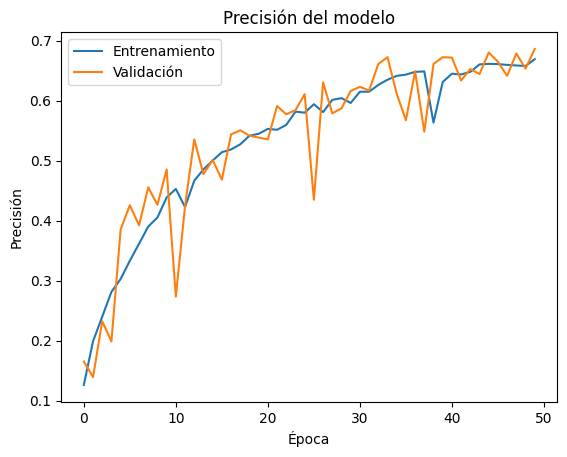

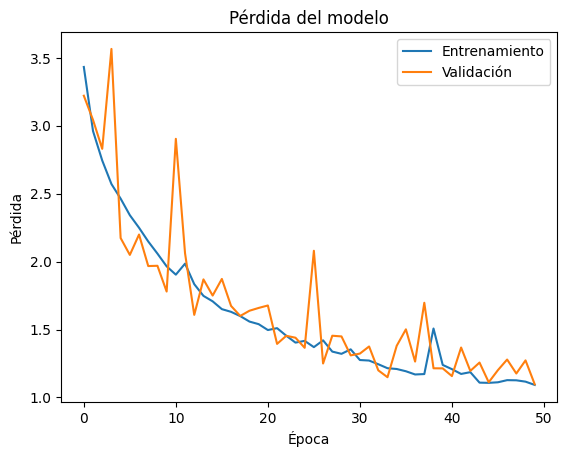

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6903 - loss: 1.0562


Pérdida: 1.0968337059020996, Precisión: 0.686214804649353


In [44]:
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import TimeDistributed, Conv1D, MaxPooling1D, Flatten, LSTM, Dropout, BatchNormalization, Dense, Masking
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


archivo_refinado = r"..\data\processed\s1.txt"
labels, arrays = leer_entrenamiento(archivo_refinado)

# Define los hiperparámetros
input_dim = len(points_cles_interessants)  # Número de keypoints por frame (ejemplo)
longitud = calcular_limite_longitud(arrays)
longitudes = [len(seq) for seq in arrays]

classes = np.unique(labels).size 
arrays_threshold = []
labels_threshold = []

for i in range(len(arrays)):
    if len(arrays[i])<=longitud:
        arrays_threshold.append(arrays[i])
        labels_threshold.append(labels[i])
            
num_classes = np.unique(labels).size      # Número de palabras a reconocer

time_steps = longitud  # Número de frames en cada secuencia

# Crear un mapeo de etiquetas únicas a enteros
unique_labels = np.unique(labels_threshold)
label_to_int = {label: idx for idx, label in enumerate(unique_labels)}

# Convertir las etiquetas usando el mapeo
labels_threshold_int = [label_to_int[label] for label in labels_threshold]

y_train = to_categorical(labels_threshold_int, num_classes=num_classes)

X_padding = aplicar_padding(arrays_threshold,longitud)

# Dividir en conjuntos de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X_padding, y_train, test_size=0.2, random_state=42)

model = Sequential([
    # TimeDistributed para procesar las relaciones espaciales (keypoints)
    TimeDistributed(Conv1D(filters=32, kernel_size=3, activation='relu'), input_shape=(15, 20, 2)),
    TimeDistributed(MaxPooling1D(pool_size=2)),
    TimeDistributed(Flatten()),  # Reduce las dimensiones a (15, features)
    
    # LSTM para capturar patrones temporales
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    BatchNormalization(),
    LSTM(64),
    Dropout(0.3),
    BatchNormalization(),
    
    # Capa densa intermedia
    Dense(64, activation='relu'),
    Dropout(0.3),
    
    # Capa de salida para clasificación
    Dense(num_classes, activation='softmax')
])

# Compilación del modelo
model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

# Mostrar resumen del modelo
model.summary()

# Entrenar el modelo
epochs = 50
batch_size = 32

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size
)

# Graficar resultados
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión del modelo')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida del modelo')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

# Evaluar el modelo
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Pérdida: {loss}, Precisión: {accuracy}")

# Guardar el modelo
model.save('modelo_clasificador_lstm_rotacion.h5')

Epoch 1/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 244ms/step - accuracy: 0.2637 - loss: 0.8391 - val_accuracy: 0.8889 - val_loss: 0.6617
Epoch 2/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.2283 - loss: 0.7747 - val_accuracy: 0.0000e+00 - val_loss: 0.6492
Epoch 3/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.2940 - loss: 0.6649 - val_accuracy: 0.0000e+00 - val_loss: 0.6375
Epoch 4/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.2733 - loss: 0.6252 - val_accuracy: 0.0000e+00 - val_loss: 0.6375
Epoch 5/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.2282 - loss: 0.5419 - val_accuracy: 0.0000e+00 - val_loss: 0.6297
Epoch 6/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.2270 - loss: 0.4702 - val_accuracy: 0.0000e+00 - val_loss: 0.5816
Epoch 7/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.2975 - loss: 0.4446 - val_accuracy: 0.0000e+00 - val_loss: 0.5390
Epoch 8/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.2585 - loss: 0.4141 - val_acc

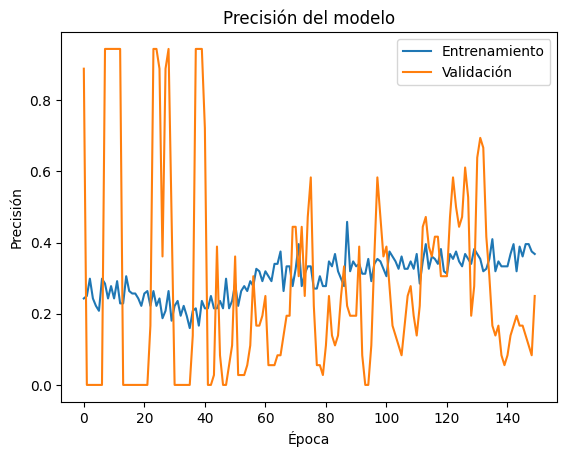

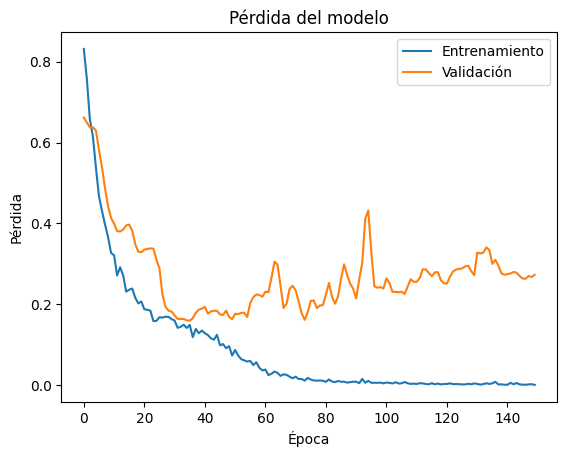

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2500 - loss: 0.2300


Pérdida: 0.27340972423553467, Precisión: 0.25


In [62]:
def crear_ventanas_combinadas(arrays, labels, window_size, slide):

    ventanas = []
    etiquetas = []
    for seq, label_seq in zip(arrays, labels):
        for i in range(0, len(seq) - window_size + 1, slide):
            ventana = seq[i:i + window_size]
            etiquetas_ventana = label_seq[i:i + window_size]
            
            # Combinar etiquetas únicas presentes en la ventana
            etiquetas_unicas = sorted(set(etiquetas_ventana))  # Ordenadas para consistencia
            etiquetas.append(etiquetas_unicas)
            ventanas.append(ventana)
    
    return np.array(ventanas), etiquetas

def etiquetas_a_one_hot(etiquetas, etiqueta_unica_total):

    etiquetas_one_hot = []
    etiqueta_to_idx = {etiqueta: idx for idx, etiqueta in enumerate(etiqueta_unica_total)}
    num_clases = len(etiqueta_unica_total)
    
    for etiquetas_lista in etiquetas:
        vector = np.zeros(num_clases)
        for etiqueta in etiquetas_lista:
            idx = etiqueta_to_idx[etiqueta]
            vector[idx] = 1
        etiquetas_one_hot.append(vector)
    
    return np.array(etiquetas_one_hot)

if __name__ == "__main__":
    
    #cargamos_datos()
    # Cargar y preparar los datos
    archivo_refinado = r"..\data\processed\s1.txt"
    labels, arrays = leer_entrenamiento(archivo_refinado)
    
    # Define parámetros de la ventana
    window_size = 15
    slide = 5
    
    # Crear ventanas y sus etiquetas combinadas
    ventanas, etiquetas_combinadas = crear_ventanas_combinadas(arrays, labels, window_size, slide)
    
    # Obtener todas las etiquetas únicas posibles
    etiquetas_unicas_totales = sorted(set([etiqueta for etiquetas in etiquetas_combinadas for etiqueta in etiquetas]))
    
    # Convertir etiquetas combinadas a one-hot encoding
    y = etiquetas_a_one_hot(etiquetas_combinadas, etiquetas_unicas_totales)
    
    # Dividir en conjuntos de entrenamiento y validación
    X_train, X_val, y_train, y_val = train_test_split(ventanas, y, test_size=0.2, random_state=42)
    
    # Construir el modelo
    input_shape = (window_size, ventanas.shape[2], ventanas.shape[3])  # Ajusta la dimensión según tus datos
    model = Sequential([
        # TimeDistributed para procesar las relaciones espaciales (keypoints)
        TimeDistributed(Conv1D(filters=32, kernel_size=3, activation='relu'), input_shape=(15, 20, 2)),
        TimeDistributed(MaxPooling1D(pool_size=2)),
        TimeDistributed(Flatten()),  # Reduce las dimensiones a (15, features)
        
        # LSTM para capturar patrones temporales
        LSTM(256, return_sequences=True),
        Dropout(0.3),
        BatchNormalization(),
        LSTM(124),
        Dropout(0.3),
        BatchNormalization(),
        
        # Capa densa intermedia
        Dense(64, activation='relu'),
        Dropout(0.3),
        
        # Capa de salida para clasificación
         Dense(y.shape[1], activation='sigmoid')
    ])
    
    
    # Compilar el modelo
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # Entrenar el modelo
    epochs = 150
    batch_size = 32
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size
    )
    
    # Graficar resultados
    plt.plot(history.history['accuracy'], label='Entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Validación')
    plt.title('Precisión del modelo')
    plt.xlabel('Época')
    plt.ylabel('Precisión')
    plt.legend()
    plt.show()
    
    plt.plot(history.history['loss'], label='Entrenamiento')
    plt.plot(history.history['val_loss'], label='Validación')
    plt.title('Pérdida del modelo')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.show()
    
    # Evaluar el modelo
    loss, accuracy = model.evaluate(X_val, y_val)
    print(f"Pérdida: {loss}, Precisión: {accuracy}")
    
    # Guardar el modelo
    model.save('modelo_clasificador_lstm_rotacion.h5')